In [ ]:
!pip install --upgrade pip
!pip install tensorflow
!pip install numpy pandas matplotlib

     |████████████████████████████████| 1.4 MB 1.8 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.0.1
    Uninstalling pip-20.0.1:
      Successfully uninstalled pip-20.0.1
     |████████████████████████████████| 421.8 MB 15 kB/s s eta 0:00:01
ERROR: Could not install packages due to an EnvironmentError: [Errno 13] Permission denied: '/opt/venv/lib/python3.7/site-packages/tensorflow_core/libtensorflow_framework.so.2'
Consider using the `--user` option or check the permissions.



In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense, Dropout, Concatenate, Input, Flatten
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.regularizers import l2, l1, l1_l2

import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

Test 1
GRU ->
Linear -> 
Sigmoid


In [ ]:
#to plot loss over time 



In [ ]:
tweets = list()
targets = list()

with open('../preprocessing_scripts/new_train_data.txt', 'r') as f:
  tweets = f.readlines()
print(len(tweets))

with open('../preprocessing_scripts/targets.csv', 'r') as f:
  targets = f.readlines()
targets2 = list()
for i in range(0, len(targets)): 
    targets2.append(int(targets[i]))
targets = targets2

pd.Series(targets).value_counts()

7613


0    4342
1    3271
dtype: int64

In [ ]:
with open('../preprocessing_scripts/keyword.csv', 'r') as f:
  keywords = f.readlines()

ktokenizer = Tokenizer(30)
ktokenizer.fit_on_texts(keywords)
ktokenized_version = ktokenizer.texts_to_sequences(keywords)
ktokenized_version = pad_sequences(ktokenized_version, maxlen=15)[:6000]

In [ ]:
def WideandDeep(max_seq_len):
    keywords = Input(shape=(15,), dtype='int32')
    key_Dense = Dense(10,activation = 'relu')(keywords)
    main_input = Input(shape=(100,), dtype='int32')
    emb = Embedding(vocab_size, 64)(main_input)
    bi = Bidirectional(GRU(64, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))(emb)
    bi = Bidirectional(GRU(64,return_sequences=True, dropout=0.5, recurrent_dropout=0.5))(bi)
    batch = BatchNormalization()(bi)
    flat = Flatten()(batch)
    concat = Concatenate()([flat,key_Dense])
    comb = Dense(64, activation='relu',kernel_regularizer=l1_l2())(concat)
    drop = Dropout(0.5)(comb)
    output = Dense(1, activation='sigmoid')(drop)
    return Model(inputs = [keywords,main_input],outputs = [output])
    

In [ ]:


max_words = 14000
tokenizer = Tokenizer(num_words=max_words)


In [ ]:
trainX = tweets[:6000]
trainY = targets[:6000]

testX = tweets[6000:]
testY = tweets[6000:]

maxlen = 100



tokenizer.fit_on_texts(trainX)
tokenized_version = tokenizer.texts_to_sequences(trainX)
tokenized_version = pad_sequences(tokenized_version, maxlen=maxlen)
print(tokenized_version)

[[   0    0    0 ...  165   58    1]
 [   0    0    0 ...   84   15    1]
 [   0    0    0 ...   33 1064    1]
 ...
 [   0    0    0 ...   10 2164    1]
 [   0    0    0 ...    8  682    1]
 [   0    0    0 ...  866 3316    1]]


In [ ]:
from tensorflow.keras import backend as K
def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
def f1(y_true, y_pred):
    precisionf = precision(y_true, y_pred)
    recallf = recall(y_true, y_pred)
    return 2*((precisionf*recallf)/(precisionf+recallf+K.epsilon()))

In [ ]:
vocab_size = 14000
#model = models.NaiveModel(vocab_size)
model = WideandDeep(vocab_size)
es = EarlyStopping(patience=5)
mcp_save = ModelCheckpoint('widendeep.mdl_wts.hdf5', save_best_only=True, monitor='val_f1')
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=['accuracy',f1,recall,precision]) 

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 64)      896000      input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 100, 128)     49920       embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 100, 128)     74496       bidirectional[0][0]              
______________________________________________________________________________________________

In [ ]:
trainY = np.array(trainY)
history = model.fit(x=[ktokenized_version,tokenized_version], y=trainY, batch_size = 128, epochs=10, validation_split = 0.2,callbacks=[es,mcp_save])

Train on 4800 samples, validate on 1200 samples
Epoch 1/10
4800/4800 [==============================] - 34s 7ms/sample - loss: 26.0716 - accuracy: 0.5246 - f1: 0.3534 - recall: 0.3253 - precision: 0.4116 - val_loss: 4.7919 - val_accuracy: 0.5742 - val_f1: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/10
4800/4800 [==============================] - 25s 5ms/sample - loss: 2.9962 - accuracy: 0.5442 - f1: 0.2486 - recall: 0.1953 - precision: 0.4059 - val_loss: 2.2512 - val_accuracy: 0.5742 - val_f1: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/10
4800/4800 [==============================] - 24s 5ms/sample - loss: 2.1486 - accuracy: 0.6450 - f1: 0.4346 - recall: 0.3491 - precision: 0.6238 - val_loss: 2.1725 - val_accuracy: 0.5775 - val_f1: 0.0180 - val_recall: 0.0098 - val_precision: 0.1800
Epoch 4/10
4800/4800 [==============================] - 24s 5ms/sample - loss: 1.8758 - accuracy: 0.8077 - f1: 0.7515 - recall: 0.7081 - precision: 0.

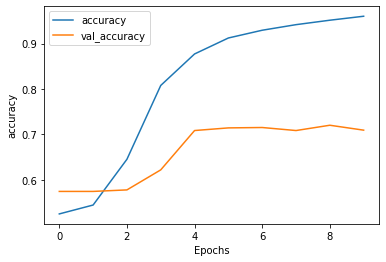

In [ ]:
plot_graphs(history,"accuracy")




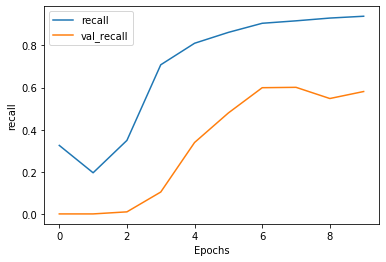

In [ ]:
plot_graphs(history,"recall")

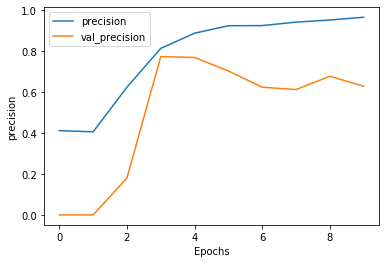

In [ ]:
plot_graphs(history,"precision")

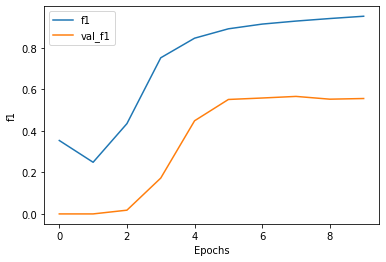

In [ ]:
plot_graphs(history,"f1")

In [ ]:
testmodel = load_model("widendeep.mdl_wts.hdf5",custom_objects = {'f1':f1,'recall':recall,"precision":precision})

In [ ]:
testdata = pd.read_csv("new_test_data.txt",delimiter= '\n', index_col=False,names=["text"])["text"]
keywordstest = pd.read_csv("../preprocessing_scripts/test.csv")["keyword"]

In [ ]:
testdata

0       <START> Just happened a terrible car crash <STOP>
1       <START> Heard MONEY is different cities, stay ...
2       <START> there is a forest fire at spot pond, N...
3        <START> Apocalypse lighting <HASH> <HASH> <STOP>
4        <START> ORG kills CARDINAL in GPE and GPE <STOP>
                              ...                        
3258    <START> EARTHQUAKE SAFETY GPE <NASCII> SAFETY ...
3259    <START> Storm in DATE worse than last hurrican...
3260    <START> Green Line derailment in GPE <LINK> <S...
3261             <START> ORG issues ORG HWO <LINK> <STOP>
3262    <START> <HASH> PERSON has activated its Munici...
Name: text, Length: 3263, dtype: object

In [ ]:
keywordstest

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
3258    NaN
3259    NaN
3260    NaN
3261    NaN
3262    NaN
Name: keyword, Length: 3263, dtype: object

In [ ]:
def tokenate(maxlen,data):
    data = list(data[0])
    tokenizer = Tokenizer(maxlen)
    tokenizer.fit_on_texts(data)
    tokenized_version = tokenizer.texts_to_sequences(data)
    tokenized_version = pad_sequences(tokenized_version, maxlen=maxlen)
    return tokenized_version

In [ ]:
key_list =list(keywordstest.values)
keywordstest.value_counts()

deluged                  23
rubble                   22
demolished               22
obliteration             21
snowstorm                21
                         ..
threat                    5
fatalities                5
radiation%20emergency     5
inundation                4
epicentre                 1
Name: keyword, Length: 221, dtype: int64

In [ ]:
keywordstest = tokenate(100,key_list)

TypeError: 'float' object is not iterable

In [ ]:
testx = tokenate(100,test)

AttributeError: 'numpy.ndarray' object has no attribute 'lower'